In [1]:
import os 
import json
import pickle
import sys
sys.path.insert(0, '../')
from src.DataSaver import DataSaver
from src.DynamicSystemAnalyzer import *
from src.PerformanceAnalyzer import *
from src.RNN_numpy import RNN_numpy
from src.utils import get_project_root, numpify, orthonormalize
from src.Trainer import Trainer
from src.RNN_torch import RNN_torch
from src.Task import *
from matplotlib import pyplot as plt
import torch
import time
from sklearn.decomposition import PCA

In [3]:
dict_path = "/Users/jiayizhang/Documents/code_base/rnn-coach/"
task_name = "ALM"
activation = "relu"
config_dict = json.load(open(os.path.join(dict_path, "data", "configs", f'train_config_{task_name}_{activation}_more_trials.json'), mode="r"))
print("config file last updated: ", config_dict["last_compiled"])

config file last updated:  2023-11-01 19:57:33.859506


In [4]:
# Task:
n_steps = config_dict["n_steps"]
task_params = config_dict["task_params"]

In [5]:
# Trainer:
lambda_orth = config_dict["lambda_orth"]
lambda_r = config_dict["lambda_r"]
max_iter = config_dict["max_iter"]
tol = config_dict["tol"]
lr = config_dict["lr"]
weight_decay = config_dict["weight_decay"]
same_batch = config_dict["same_batch"]

In [6]:
# RNN config:
N = config_dict["N"]
dt = config_dict["dt"]
tau = config_dict["tau"]
mask = np.array(config_dict["mask"])
input_size = config_dict["num_inputs"]
output_size = config_dict["num_outputs"]
if (activation == "relu"):
    activation = lambda x: torch.maximum(x, torch.tensor(0))
constrained = config_dict["constrained"]
# constrained = False
sigma_inp = config_dict["sigma_inp"]
sigma_rec = config_dict["sigma_rec"]
connectivity_density_rec = config_dict["connectivity_density_rec"]
spectral_rad = config_dict["sr"]
spectral_rad = 2
seed = config_dict["seed"]

rng = torch.Generator()
if not (seed is None):
    rng.manual_seed(seed)

In [7]:
# creating instances:
rnn_torch = RNN_torch(N=N, dt=dt, tau=tau, input_size=input_size,   
                      output_size=output_size,
                      activation=activation, constrained=constrained,
                      sigma_inp=sigma_inp, sigma_rec=sigma_rec,
                      connectivity_density_rec=connectivity_density_rec,
                      spectral_rad=spectral_rad,
                      random_generator=rng, device="cpu")
task = eval("Task" + task_name)(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(rnn_torch.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)
trainer = Trainer(RNN=rnn_torch, Task=task,
                  max_iter=max_iter, tol=tol,
                  optimizer=optimizer, criterion=criterion,
                  lambda_orth=lambda_orth, lambda_r=lambda_r)
datasaver = None

Using cpu for RNN!


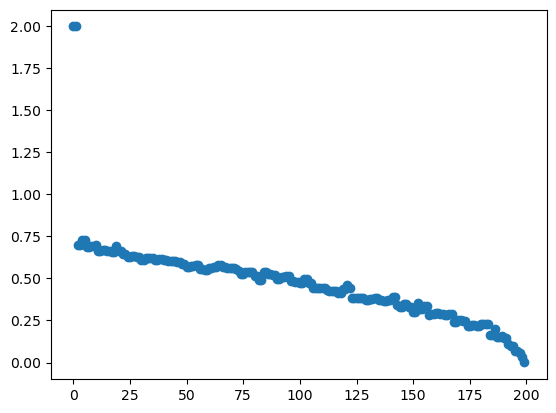

In [9]:
# inspect start eigenvalue distribution for the RNN
w, v = torch.linalg.eig(rnn_torch.W_rec)
rad = torch.absolute(w).detach().numpy()
plt.scatter(range(len(rad)), rad)

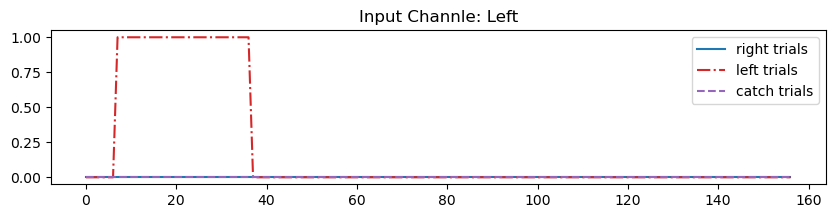

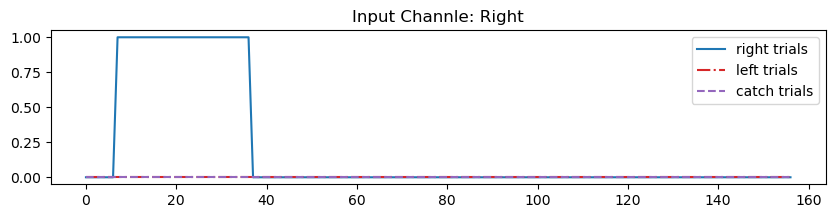

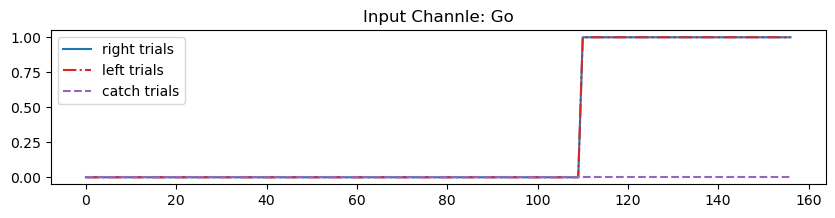

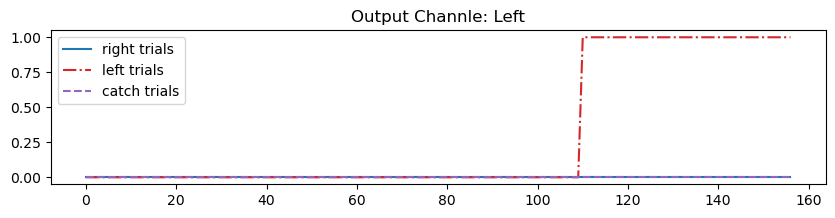

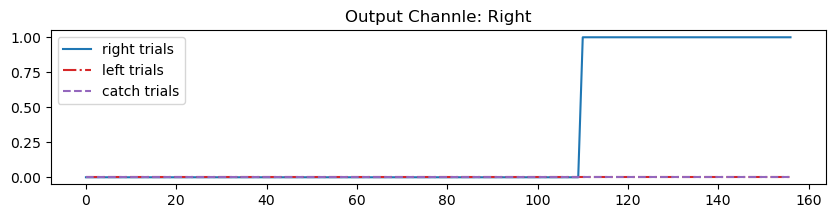

In [45]:
# visualize inputs and targets

inputs, targets = task.get_batch()
n_r, n_l = task_params["n_rights"], task_params["n_lefts"]
n_c = task_params["n_catches"]
channel_names = ["Left", "Right", "Go"]

for i in range(input_size):  # left, right, go
    fig = plt.figure(figsize = (10, 2))
    plt.plot(np.average(inputs[i,:,:n_r], axis=1), c='tab:blue', label="right trials")
    plt.plot(np.average(inputs[i,:,n_r:n_r+n_l], axis=1), c='tab:red', ls="-.", label="left trials")
    plt.plot(np.average(inputs[i,:,n_r+n_l:n_c+n_r+n_l], axis=1), c='tab:purple', ls="--", label="catch trials")
    plt.title(f"Input Channle: {channel_names[i]}")
    plt.legend()

for i in range(output_size): # left, right
    fig = plt.figure(figsize = (10, 2))
    plt.plot(np.average(targets[i,:,:n_r], axis=1), c='tab:blue', label="right trials")
    plt.plot(np.average(targets[i,:,n_r:n_r+n_l], axis=1), c='tab:red', ls="-.", label="left trials")
    plt.plot(np.average(targets[i,:,n_r+n_l:n_c+n_r+n_l], axis=1), c='tab:purple', ls="--", label="catch trials")
    plt.title(f"Output Channle: {channel_names[i]}")
    plt.legend()


In [46]:
# run training
rnn_trained, train_losses, val_losses, net_params = trainer.run_training(train_mask=mask, same_batch=same_batch)

tensor(0.0786)
iteration 0, train loss: 2.01936, validation loss: 0.078583
tensor(0.0843)
iteration 1, train loss: 0.098884, validation loss: 0.084267
tensor(0.0871)
iteration 2, train loss: 0.092925, validation loss: 0.08715
tensor(0.0888)
iteration 3, train loss: 0.093329, validation loss: 0.088806
tensor(0.0899)
iteration 4, train loss: 0.093908, validation loss: 0.089859
tensor(0.0906)
iteration 5, train loss: 0.093773, validation loss: 0.090628
tensor(0.0912)
iteration 6, train loss: 0.094506, validation loss: 0.091202
tensor(0.0916)
iteration 7, train loss: 0.095218, validation loss: 0.091626
tensor(0.0920)
iteration 8, train loss: 0.095438, validation loss: 0.09195
tensor(0.0922)
iteration 9, train loss: 0.094116, validation loss: 0.09221
tensor(0.0924)
iteration 10, train loss: 0.095616, validation loss: 0.092413
tensor(0.0926)
iteration 11, train loss: 0.095557, validation loss: 0.092571
tensor(0.0927)
iteration 12, train loss: 0.095633, validation loss: 0.092695
tensor(0.0928

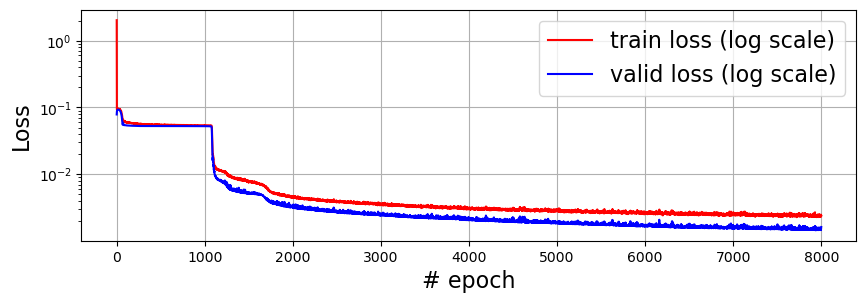

In [47]:
# visualize loss

fig_trainloss = plt.figure(figsize=(10, 3))
plt.plot(train_losses, color='r', label='train loss (log scale)')
plt.plot(val_losses, color='b', label='valid loss (log scale)')
plt.yscale("log")
plt.grid(True)
plt.xlabel("# epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(fontsize=16)


In [48]:
# validate
RNN_valid = RNN_numpy(N=net_params["N"],
                      dt=net_params["dt"],
                      tau=net_params["tau"],
                      activation=numpify(activation),
                      W_inp=net_params["W_inp"],
                      W_rec=net_params["W_rec"],
                      W_out=net_params["W_out"],
                      bias_rec=np.zeros(N),
                      y_init=net_params["y_init"])

In [10]:
input_batch_valid, target_batch_valid = task.get_batch()


In [50]:
RNN_valid.clear_history()
RNN_valid.run(input_timeseries=input_batch_valid, sigma_inp=sigma_inp, sigma_rec=sigma_rec)
output = RNN_valid.get_output()

100 100 100


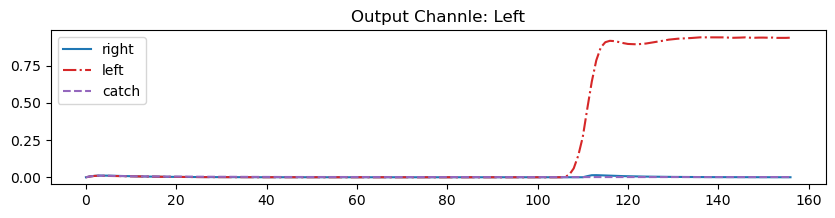

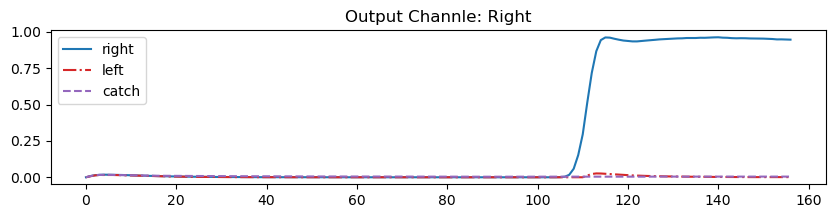

In [51]:
# visualize RNN output
n_r, n_l = task_params["n_rights"], task_params["n_lefts"]
n_c = task_params["n_catches"]
print(n_r, n_l, n_c)
ch_names = ["Left", "Right"]

for i in range(output_size): # left, right
    fig = plt.figure(figsize = (10, 2))
    plt.plot(np.average(output[i,:,:n_r], axis=1), c='tab:blue', label="right")
    plt.plot(np.average(output[i,:,n_r:n_r+n_l], axis=1), c='tab:red', ls="-.", label="left")
    plt.plot(np.average(output[i,:,n_r+n_l:n_c+n_r+n_l], axis=1), c='tab:purple', ls="--", label="catch")
    plt.title(f"Output Channle: {ch_names[i]}")
    plt.legend()

In [52]:
# rnn_trained, train_losses, val_losses, net_params
# save RNN data
RNN_valid.clear_history()
RNN_valid.run(input_batch_valid, sigma_inp=sigma_inp, sigma_rec=sigma_rec)
neural_traces = RNN_valid.get_history()
traces_data = {}
traces_data["inputs"] = input_batch_valid
traces_data["targets"] = target_batch_valid
traces_data["traces"] = neural_traces
traces_data["outputs"] = RNN_valid.get_output()
traces_data["net_params"] = net_params

path_to_traces = os.path.join("../data/trained_RNNs/ALM/","test","trained_RNN_updated_go.pkl")
pickle.dump(traces_data, open(path_to_traces, "wb+"))